## Q(a) 
To get you started, an interesting observation you can make is that NVDA price remained
mostly flat between 2010 and 2015, and then it started to soar. In one sentence, explain why
(remember this is a computer science class, not finance). 

## My response: 
Since NVidia has been producing CPU/GPU, the need for these merchandises soared (such as the Bit-Coin business ) during 2014-15. It also facilitates DNN research since more powerful GPUs are available and able to perform heavy computations for DNN needs, which in turn result in higher needs in CPUs/GPUs.

## Q(b) 
Now a quantitative research intern at a hedge fund designs a three-layer ANN with 200
hidden neurons to predict the next day’s NVDA adjusted closing price using the past thirty days’. Do
you see any issue to train such a network on the data provided? Please explain (you will need to do
some math here). 

## My response: 
It may result in overfitting since the parameters will be 30x200+200+200x1+1 = 6401 whereas the input neurons are 30. The # of parameters >> the # of training data. 

In [241]:
# first neural network with keras tutorial
import numpy as np
import os
import time
from datetime import datetime
from numpy.random import seed
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
# np.random.seed(1337) # for reproducibility
from matplotlib.dates import DateFormatter
from matplotlib import dates


# tf.random.set_seed(1234) 

## Splitting data X into train:val:test = 60:20:20

In [250]:
# load column[Adj Close] into df
df = pd.read_csv('NVDA.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
date = df['Date']
date = pd.to_datetime(date, format='%Y-%m-%d')

df = df.set_index('Date')
X = df['Adj Close'].to_numpy()

# split into 60:20:20
train = X[0:int(len(X)*0.6)+1]
val = X[int(len(X)*0.6)+1:int(len(X)*0.8)+1]
test = X[int(len(X)*0.8)+1:]

df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,1.750000,1.953125,1.552083,1.640625,1.508412,67867200
1999-01-25,1.770833,1.833333,1.640625,1.812500,1.666436,12762000
1999-01-26,1.833333,1.869792,1.645833,1.671875,1.537143,8580000
1999-01-27,1.677083,1.718750,1.583333,1.666667,1.532354,6109200
1999-01-28,1.666667,1.677083,1.651042,1.661458,1.527566,5688000
...,...,...,...,...,...,...
2021-03-01,555.000000,557.000000,542.130005,553.669983,553.669983,8802500
2021-03-02,556.000000,556.820007,535.840027,536.250000,536.250000,6585500
2021-03-03,537.049988,538.059998,511.950012,512.190002,512.190002,9408000


### A nice format for print out data in the plots
source: https://stackoverflow.com/questions/48428729/matplotlib-dates-yearlocator-with-odd-intervals

In [219]:
def format_xaxis(fig):

     years = dates.YearLocator(10,month=1,day=1)
     years1=dates.YearLocator(2,month=1,day=1)
     dfmt = dates.DateFormatter('%Y')
     dfmt1 = dates.DateFormatter('%y')

     [i.xaxis.set_major_locator(years) for i in fig.axes]
     [i.xaxis.set_minor_locator(years1) for i in fig.axes]
     [i.xaxis.set_major_formatter(dfmt) for i in fig.axes]
     [i.xaxis.set_minor_formatter(dfmt1) for i in fig.axes]
     [i.get_xaxis().set_tick_params(which='major', pad=15) for i in fig.axes]

     for t in fig.axes:
         for tick in t.xaxis.get_major_ticks():
             tick.label1.set_horizontalalignment('center')
         for label in t.get_xmajorticklabels() :
             label.set_rotation(0)
             label.set_weight('bold')
         for label in t.xaxis.get_minorticklabels():
             label.set_fontsize('small')
         for label in t.xaxis.get_minorticklabels()[::5]:
             label.set_visible(False)

### A visualization of the dataset

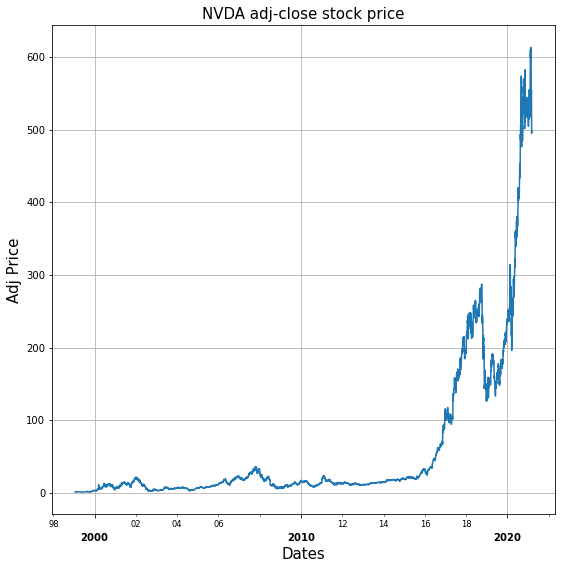

In [321]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(9, 9))

# Add x-axis and y-axis
ax.plot(df.index.values, df['Adj Close'])

# Define the date format
date_form = DateFormatter("%y-%m-%d")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))
format_xaxis(fig)

plt.xlabel('Dates', fontsize = 15)
plt.ylabel('Adj Price', fontsize = 15)
plt.grid(True)
plt.title('NVDA adj-close stock price', fontsize = 15)
plt.savefig('./images/NVDA_dataset.jpg')
plt.show()


### Data Preprocessing by Using 7-prior-Stock-Day As A Sliding Window

In [27]:

head = ['D1', 'D2', 'D3', 'D4','D5', 'D6','D7', 'D8']

# sliding window via train
ds_train = list()
for i in range(len(train)-7):
    ds_train.append([train[i], train[i+1], train[i+2], train[i+3], train[i+4], train[i+5], train[i+6], train[i+7]])
ds_train_df = pd.DataFrame(ds_train, columns = head)

x_7_train = ds_train_df[['D1','D2','D3','D4','D5','D6','D7']].to_numpy()
y_7_train = ds_train_df['D8'].to_numpy()

# sliding window via val
ds_val = list()
for i in range(len(val)-7):
    ds_val.append([val[i], val[i+1], val[i+2], val[i+3], val[i+4], val[i+5], val[i+6], val[i+7]])
ds_val_df = pd.DataFrame(ds_val, columns = head)

x_7_val = ds_val_df[['D1','D2','D3','D4','D5','D6','D7']].to_numpy()
y_7_val = ds_val_df['D8'].to_numpy()

# sliding window via test
ds_test = list()
for i in range(len(test)-7):
    ds_test.append([test[i], test[i+1], test[i+2], test[i+3], test[i+4], test[i+5], test[i+6], test[i+7]])
ds_test_df = pd.DataFrame(ds_test, columns = head)

x_7_test = ds_test_df[['D1','D2','D3','D4','D5','D6','D7']].to_numpy()
y_7_test = ds_test_df['D8'].to_numpy()

ds_train_df

,D1,D2,D3,D4,D5,D6,D7,D8
0,1.508412,1.666436,1.537143,1.532354,1.527566,1.455737,1.484468,1.369541
1,1.666436,1.537143,1.532354,1.527566,1.455737,1.484468,1.369541,1.398273
2,1.537143,1.532354,1.527566,1.455737,1.484468,1.369541,1.398273,1.474891
3,1.532354,1.527566,1.455737,1.484468,1.369541,1.398273,1.474891,1.517989
4,1.527566,1.455737,1.484468,1.369541,1.398273,1.474891,1.517989,1.465314
...,...,...,...,...,...,...,...,...
3328,13.018881,12.862586,12.890170,12.752257,12.559176,12.310936,12.163832,11.786872
3329,12.862586,12.890170,12.752257,12.559176,12.310936,12.163832,11.786872,12.025921
3330,12.890170,12.752257,12.559176,12.310936,12.163832,11.786872,12.025921,12.035111
3331,12.752257,12.559176,12.310936,12.163832,11.786872,12.025921,12.035111,11.933974


## Q(c)
So now we decide to build our own models to predict the next day’s NVDA adjusted closing
price based on the past seven days’. To extract the train/validation/test data, you may use a sliding
window approach (i.e., the first sample would be the adjusted closing prices on the seven trading days
between 1/22/99 and 2/1/99 and its label/target is $1.369541, the adjusted closing price on 2/2/99; the
second sample would be the adjusted closing prices from 1/23/99 to 2/2/99 and the label/target would
be that on 2/3/99, etc). We will build 4 two-layer ANNs, with 20, 40, 60 and 80 hidden neurons
respectively. Use ReLU activation for all the neurons, and mean squared error/sum of squared error as
the objective function. Plot the training and validation accuracy vs. training iteration (epochs) for each
model (four figures in total). Also, for each trained model, plot your predicted adjusted closing prices
from 10/1/16 to now and the actual prices with respect to time (similar to the figure I showed on the
previous page), and compute the average accuracy (MSE) of the adjusted closing prices on the test
data. Comparing the four models, what can you observe and why? Would any of them provide
satisfactory accuracy?

## My response:
During the training process, I noticed that the models were sometimes stuck and untrainable. I am assuming that the random initialization of the model makes the particular starting point of that moment at local a minimum. I have to rerun it manually(did not change the code at all). One way to address this issue is to set a fixed seed for the initialization, but my version of the tensorflow has some issues and won't let me set it as I plan. Hence my results fluctuate every time and make me have a hard time to evaluate them objectively. The best observation from my perspective is that the more neurons in a hidden layer, the more smooth the accuracy vs epochs will become. The MSE of each model is fairly low at around 60ish, which I am not sure if this accuracy meets the standard. But, again these results fluctuate and the observation is based on my case.

## Training 
Train the same architecture models with different hidden neurons, here the hyperparmeters are epochs = 50 / batchsize = 32

In [28]:
def model_fit(model, epochs, hidden_layer, batch_size, x_train, y_train, x_val, y_val):
    # define the keras 7-20-1 model
    model.add(Dense(hidden_layer, input_dim=7, activation='relu'))
    model.add(Dense(1, activation='relu'))
    # compile the keras model
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"]) #  1- (MSE/100)
    # fit the keras model on the dataset
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))
    return model, history

### 7-20-1

In [29]:
model_7_20_1 = Sequential()
model_7_20_1, history_7_20_1 = model_fit(model = model_7_20_1 ,epochs = 50, batch_size = 32, hidden_layer = 20, x_train = x_7_train, y_train = y_7_train, x_val = x_7_val, y_val = y_7_val)

Train on 3333 samples, validate on 1106 samples
Epoch 1/50
3333/3333 [==============================] - 0s 74us/step - loss: 7.3059 - mean_squared_error: 7.3059 - val_loss: 0.7972 - val_mean_squared_error: 0.7972
Epoch 2/50
3333/3333 [==============================] - 0s 29us/step - loss: 0.5841 - mean_squared_error: 0.5841 - val_loss: 0.7029 - val_mean_squared_error: 0.7029
Epoch 3/50
3333/3333 [==============================] - 0s 30us/step - loss: 0.5614 - mean_squared_error: 0.5614 - val_loss: 0.7430 - val_mean_squared_error: 0.7430
Epoch 4/50
3333/3333 [==============================] - 0s 32us/step - loss: 0.5365 - mean_squared_error: 0.5365 - val_loss: 0.5985 - val_mean_squared_error: 0.5985
Epoch 5/50
3333/3333 [==============================] - 0s 31us/step - loss: 0.5073 - mean_squared_error: 0.5073 - val_loss: 0.5540 - val_mean_squared_error: 0.5540
Epoch 6/50
3333/3333 [==============================] - 0s 27us/step - loss: 0.4815 - mean_squared_error: 0.4815 - val_loss: 0.

### 7-40-1

In [30]:
model_7_40_1 = Sequential()
model_7_40_1, history_7_40_1 = model_fit(model = model_7_40_1 ,epochs = 50, batch_size = 32, hidden_layer = 40, x_train = x_7_train, y_train = y_7_train, x_val = x_7_val, y_val = y_7_val)

Train on 3333 samples, validate on 1106 samples
Epoch 1/50
3333/3333 [==============================] - 0s 65us/step - loss: 12.4371 - mean_squared_error: 12.4371 - val_loss: 1.6508 - val_mean_squared_error: 1.6508
Epoch 2/50
3333/3333 [==============================] - 0s 29us/step - loss: 1.0944 - mean_squared_error: 1.0944 - val_loss: 1.3227 - val_mean_squared_error: 1.3227
Epoch 3/50
3333/3333 [==============================] - 0s 29us/step - loss: 0.9481 - mean_squared_error: 0.9481 - val_loss: 0.9837 - val_mean_squared_error: 0.9837
Epoch 4/50
3333/3333 [==============================] - 0s 28us/step - loss: 0.7800 - mean_squared_error: 0.7800 - val_loss: 1.3310 - val_mean_squared_error: 1.3310
Epoch 5/50
3333/3333 [==============================] - 0s 28us/step - loss: 0.6704 - mean_squared_error: 0.6704 - val_loss: 0.8199 - val_mean_squared_error: 0.8199
Epoch 6/50
3333/3333 [==============================] - 0s 32us/step - loss: 0.5783 - mean_squared_error: 0.5783 - val_loss: 

### 7-60-1

In [31]:
model_7_60_1 = Sequential()
model_7_60_1, history_7_60_1 = model_fit(model = model_7_60_1 ,epochs = 50, batch_size = 32, hidden_layer = 60, x_train = x_7_train, y_train = y_7_train, x_val = x_7_val, y_val = y_7_val)

Train on 3333 samples, validate on 1106 samples
Epoch 1/50
3333/3333 [==============================] - 0s 65us/step - loss: 13.1377 - mean_squared_error: 13.1377 - val_loss: 0.7860 - val_mean_squared_error: 0.7860
Epoch 2/50
3333/3333 [==============================] - 0s 30us/step - loss: 0.6260 - mean_squared_error: 0.6260 - val_loss: 0.7551 - val_mean_squared_error: 0.7551
Epoch 3/50
3333/3333 [==============================] - 0s 32us/step - loss: 0.5709 - mean_squared_error: 0.5709 - val_loss: 0.6510 - val_mean_squared_error: 0.6510
Epoch 4/50
3333/3333 [==============================] - 0s 29us/step - loss: 0.4624 - mean_squared_error: 0.4624 - val_loss: 0.7917 - val_mean_squared_error: 0.7917
Epoch 5/50
3333/3333 [==============================] - 0s 28us/step - loss: 0.4366 - mean_squared_error: 0.4366 - val_loss: 0.4210 - val_mean_squared_error: 0.4210
Epoch 6/50
3333/3333 [==============================] - 0s 30us/step - loss: 0.4205 - mean_squared_error: 0.4205 - val_loss: 

### 7-80-1

In [32]:
model_7_80_1 = Sequential()
model_7_80_1, history_7_80_1 = model_fit(model = model_7_80_1 ,epochs = 50, batch_size = 32, hidden_layer = 80, x_train = x_7_train, y_train = y_7_train, x_val = x_7_val, y_val = y_7_val)

Train on 3333 samples, validate on 1106 samples
Epoch 1/50
3333/3333 [==============================] - 0s 67us/step - loss: 8.0757 - mean_squared_error: 8.0757 - val_loss: 0.8469 - val_mean_squared_error: 0.8469
Epoch 2/50
3333/3333 [==============================] - 0s 30us/step - loss: 0.6114 - mean_squared_error: 0.6114 - val_loss: 0.7447 - val_mean_squared_error: 0.7447
Epoch 3/50
3333/3333 [==============================] - 0s 31us/step - loss: 0.5734 - mean_squared_error: 0.5734 - val_loss: 0.6173 - val_mean_squared_error: 0.6173
Epoch 4/50
3333/3333 [==============================] - 0s 30us/step - loss: 0.5365 - mean_squared_error: 0.5365 - val_loss: 0.8451 - val_mean_squared_error: 0.8451
Epoch 5/50
3333/3333 [==============================] - 0s 29us/step - loss: 0.4809 - mean_squared_error: 0.4809 - val_loss: 0.5235 - val_mean_squared_error: 0.5235
Epoch 6/50
3333/3333 [==============================] - 0s 30us/step - loss: 0.4396 - mean_squared_error: 0.4396 - val_loss: 0.

## Accuracy vs Epochs for each architecture

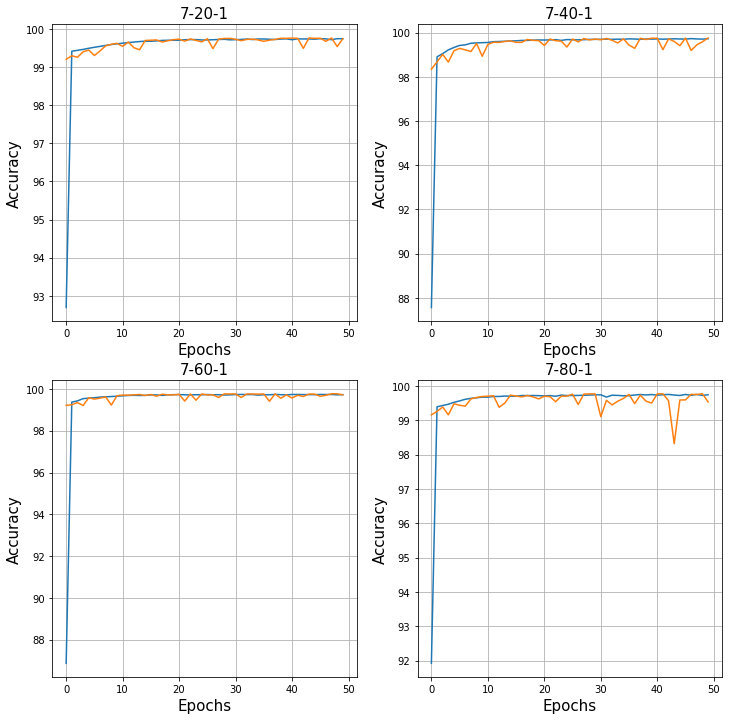

In [314]:
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.plot(100 - np.asarray(history_7_20_1.history['loss']).reshape(-1,1))
plt.plot(100.00 - np.asarray(history_7_20_1.history['val_loss']).reshape(-1,1) )
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title("7-20-1", fontsize = 15)
plt.grid(True)

plt.subplot(222)
plt.plot(100 - np.asarray(history_7_40_1.history['loss']).reshape(-1,1))
plt.plot(100.00 - np.asarray(history_7_40_1.history['val_loss']).reshape(-1,1) )
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title("7-40-1", fontsize = 15)
plt.grid(True)

plt.subplot(223)
plt.plot(100 - np.asarray(history_7_60_1.history['loss']).reshape(-1,1))
plt.plot(100.00 - np.asarray(history_7_60_1.history['val_loss']).reshape(-1,1) )
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title("7-60-1", fontsize = 15)
plt.grid(True)

plt.subplot(224)
plt.plot(100 - np.asarray(history_7_80_1.history['loss']).reshape(-1,1))
plt.plot(100.00 - np.asarray(history_7_80_1.history['val_loss']).reshape(-1,1) )
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title("7-80-1", fontsize = 15)
plt.grid(True)
plt.savefig('./images/7-prior_day_training_plot2.jpg')

 ## Predicted adjusted closing prices vs Actual adjusted closing prices

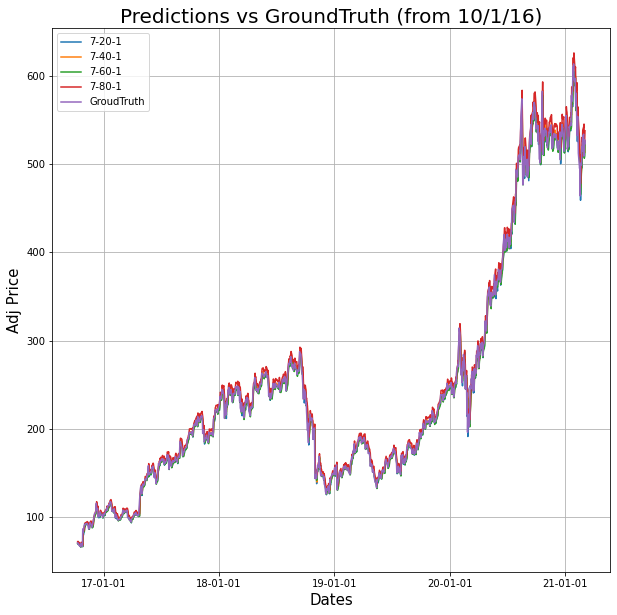

In [322]:
# Prediction
y_test_pred_7_20_1 = model_7_20_1.predict(x_7_test)
y_test_pred_7_40_1 = model_7_40_1.predict(x_7_test)
y_test_pred_7_60_1 = model_7_60_1.predict(x_7_test)
y_test_pred_7_80_1 = model_7_80_1.predict(x_7_test)

# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.plot(date[-1108:], y_test_pred_7_20_1)
ax.plot(date[-1108:], y_test_pred_7_40_1)
ax.plot(date[-1108:], y_test_pred_7_60_1)
ax.plot(date[-1108:], y_test_pred_7_80_1)
ax.plot(date[-1108:], y_7_test)

# Define the date format
date_form = DateFormatter("%y-%m-%d")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))

# Add plot details
plt.xlabel('Dates', fontsize = 15)
plt.ylabel('Adj Price', fontsize = 15)
plt.grid(True)
plt.title('Predictions vs GroundTruth (from 10/1/16)', fontsize = 20)
plt.legend(['7-20-1','7-40-1','7-60-1','7-80-1','GroudTruth'])

plt.savefig('./images/7-prior_day_prediction_plot2.jpg')
plt.show()


## Average accuracy (MSE) of the adjusted closing prices on the test data for each hidden neurons

In [35]:
from sklearn.metrics import mean_squared_error
print('Average accuracy (MSE) of the adjusted closing prices on the test data with 7-20-1 is:{:.2f}'.format(mean_squared_error(y_7_test, y_test_pred_7_20_1)))
print('Average accuracy (MSE) of the adjusted closing prices on the test data with 7-40-1 is:{:.2f}'.format(mean_squared_error(y_7_test, y_test_pred_7_40_1)))
print('Average accuracy (MSE) of the adjusted closing prices on the test data with 7-60-1 is:{:.2f}'.format(mean_squared_error(y_7_test, y_test_pred_7_60_1)))
print('Average accuracy (MSE) of the adjusted closing prices on the test data with 7-80-1 is:{:.2f}'.format(mean_squared_error(y_7_test, y_test_pred_7_80_1)))

Average accuracy (MSE) of the adjusted closing prices on the test data with 7-20-1 is:69.95
Average accuracy (MSE) of the adjusted closing prices on the test data with 7-40-1 is:64.36
Average accuracy (MSE) of the adjusted closing prices on the test data with 7-60-1 is:67.45
Average accuracy (MSE) of the adjusted closing prices on the test data with 7-80-1 is:96.20


## Q(d)
Now re-do part (c) for two deeper ANN models: one with two hidden layers (30 neurons
each), and one with three hidden layers (20 neurons each), and see if they can do a better job.
Compare your results with the ANN model in part (c) that has 60 hidden neurons in one hidden layer.
All these three models have the same number of neurons. What can you observe and why? Would any
of them provide satisfactory accuracy? 

## My response:
I noticed that the more hidden layers, the less smooth the accuracy vs epochs will become. The MSE of each model ranges from 60ish to 100 above. No threshold is given, so I can only compare them with Qb, and in this case it seems that adding more hidden layers doesn’t help a lot.

In [36]:
# define the keras 7-20-20-20-1 model
model_7_20_20_20_1 = Sequential()
model_7_20_20_20_1.add(Dense(20, input_dim=7, activation='relu'))
model_7_20_20_20_1.add(Dense(20, activation='relu'))
model_7_20_20_20_1.add(Dense(20, activation='relu'))
model_7_20_20_20_1.add(Dense(1, activation='relu'))
# compile the keras model
model_7_20_20_20_1.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
# fit the keras model on the dataset
history_7_20_20_20_1 = model_7_20_20_20_1.fit(x_7_train, y_7_train, epochs=20, batch_size=32, validation_data=(x_7_val, y_7_val))

Train on 3333 samples, validate on 1106 samples
Epoch 1/20
3333/3333 [==============================] - 0s 83us/step - loss: 15.0317 - mean_squared_error: 15.0317 - val_loss: 0.7094 - val_mean_squared_error: 0.7094
Epoch 2/20
3333/3333 [==============================] - 0s 31us/step - loss: 0.6093 - mean_squared_error: 0.6093 - val_loss: 0.7669 - val_mean_squared_error: 0.7669
Epoch 3/20
3333/3333 [==============================] - 0s 32us/step - loss: 0.5892 - mean_squared_error: 0.5892 - val_loss: 0.8337 - val_mean_squared_error: 0.8337
Epoch 4/20
3333/3333 [==============================] - 0s 31us/step - loss: 0.5771 - mean_squared_error: 0.5771 - val_loss: 0.6548 - val_mean_squared_error: 0.6548
Epoch 5/20
3333/3333 [==============================] - 0s 33us/step - loss: 0.5512 - mean_squared_error: 0.5512 - val_loss: 0.8724 - val_mean_squared_error: 0.8724
Epoch 6/20
3333/3333 [==============================] - 0s 33us/step - loss: 0.5238 - mean_squared_error: 0.5238 - val_loss: 

In [37]:
# define the keras 7-20-20-20-1 model
model_7_30_30_1 = Sequential()
model_7_30_30_1.add(Dense(30, input_dim=7, activation='relu'))
model_7_30_30_1.add(Dense(30, activation='relu'))
model_7_30_30_1.add(Dense(1, activation='relu'))
# compile the keras model
model_7_30_30_1.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
# fit the keras model on the dataset
history_7_30_30_1 = model_7_30_30_1.fit(x_7_train, y_7_train, epochs=20, batch_size=32, validation_data=(x_7_val, y_7_val))

Train on 3333 samples, validate on 1106 samples
Epoch 1/20
3333/3333 [==============================] - 0s 79us/step - loss: 0.8128 - mean_squared_error: 0.8128 - val_loss: 0.5721 - val_mean_squared_error: 0.5721
Epoch 2/20
3333/3333 [==============================] - 0s 32us/step - loss: 0.3997 - mean_squared_error: 0.3997 - val_loss: 0.4010 - val_mean_squared_error: 0.4010
Epoch 3/20
3333/3333 [==============================] - 0s 37us/step - loss: 0.3447 - mean_squared_error: 0.3447 - val_loss: 0.3075 - val_mean_squared_error: 0.3075
Epoch 4/20
3333/3333 [==============================] - 0s 39us/step - loss: 0.3396 - mean_squared_error: 0.3396 - val_loss: 0.6317 - val_mean_squared_error: 0.6317
Epoch 5/20
3333/3333 [==============================] - 0s 34us/step - loss: 0.3465 - mean_squared_error: 0.3465 - val_loss: 0.3077 - val_mean_squared_error: 0.3077
Epoch 6/20
3333/3333 [==============================] - 0s 31us/step - loss: 0.3316 - mean_squared_error: 0.3316 - val_loss: 0.

## Accuracy vs Epochs for Each Architecture

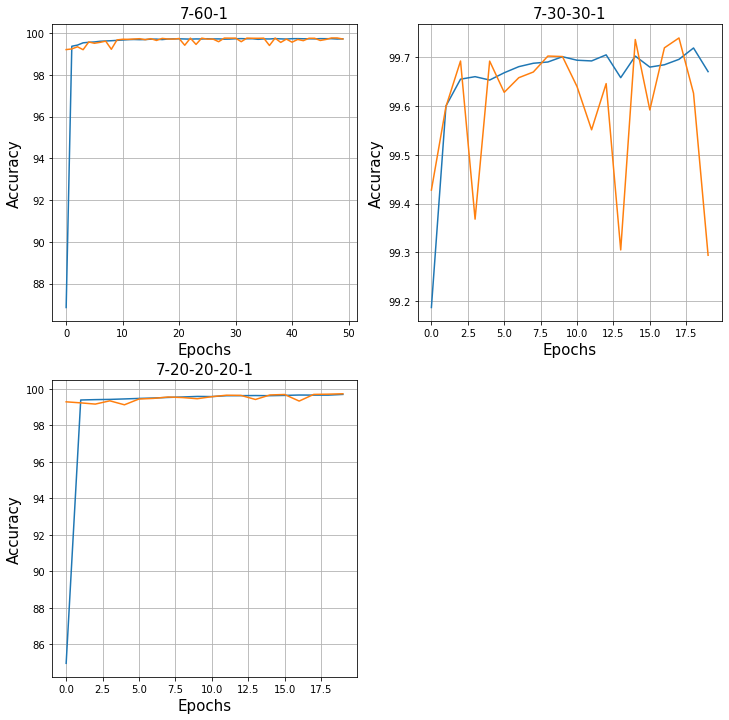

In [312]:
plt.figure(figsize=(12, 12))


plt.subplot(221)
plt.plot(100 - np.asarray(history_7_60_1.history['loss']).reshape(-1,1))
plt.plot(100.00 - np.asarray(history_7_60_1.history['val_loss']).reshape(-1,1) )
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title("7-60-1", fontsize = 15)
plt.grid(True)

plt.subplot(222)
plt.plot(100 - np.asarray(history_7_30_30_1.history['loss']).reshape(-1,1))
plt.plot(100.00 - np.asarray(history_7_30_30_1.history['val_loss']).reshape(-1,1) )
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title("7-30-30-1", fontsize = 15)
plt.grid(True)

plt.subplot(223)
plt.plot(100 - np.asarray(history_7_20_20_20_1.history['loss']).reshape(-1,1))
plt.plot(100.00 - np.asarray(history_7_20_20_20_1.history['val_loss']).reshape(-1,1) )
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title("7-20-20-20-1", fontsize = 15)
plt.grid(True)

plt.savefig('./images/7-prior_day_training_plot.jpg')


 ## Predicted adjusted closing prices vs Actual adjusted closing prices

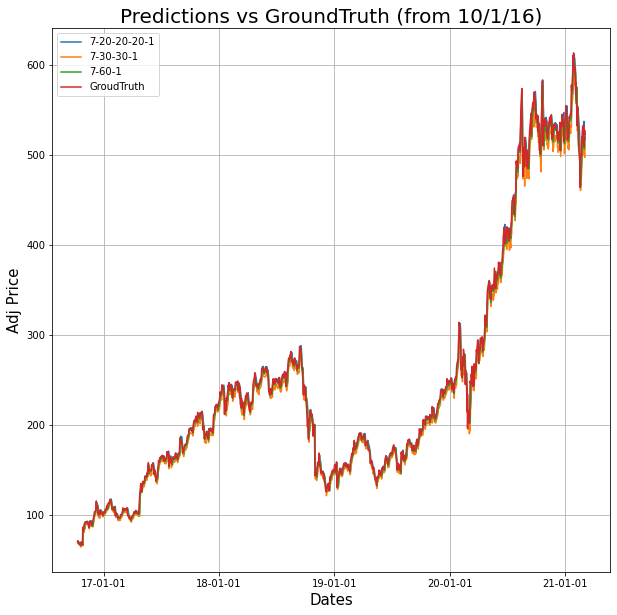

In [323]:
# Prediction
y_test_pred_7_20_20_20_1 = model_7_20_20_20_1.predict(x_7_test)
y_test_pred_7_30_30_1 = model_7_30_30_1.predict(x_7_test)
y_test_pred_7_60_1 = model_7_60_1.predict(x_7_test)

# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.plot(date[-1108:], y_test_pred_7_20_20_20_1)
ax.plot(date[-1108:], y_test_pred_7_30_30_1)
ax.plot(date[-1108:], y_test_pred_7_60_1)
ax.plot(date[-1108:], y_7_test)

# Define the date format
date_form = DateFormatter("%y-%m-%d")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))

# Add plot details
plt.xlabel('Dates', fontsize = 15)
plt.ylabel('Adj Price', fontsize = 15)
plt.grid(True)
plt.title('Predictions vs GroundTruth (from 10/1/16)', fontsize = 20)
plt.legend(['7-20-20-20-1','7-30-30-1','7-60-1','GroudTruth'])

plt.savefig('./images/7-prior_day_prediction_plot.jpg')
plt.show()


## Average accuracy (MSE) of the adjusted closing prices on the test data for each architecture

In [40]:
from sklearn.metrics import mean_squared_error
print('Average accuracy (MSE) of the adjusted closing prices on the test data with 7-20-1 is:{:.2f}'.format(mean_squared_error(y_7_test, y_test_pred_7_20_20_20_1)))
print('Average accuracy (MSE) of the adjusted closing prices on the test data with 7-40-1 is:{:.2f}'.format(mean_squared_error(y_7_test, y_test_pred_7_30_30_1)))
print('Average accuracy (MSE) of the adjusted closing prices on the test data with 7-60-1 is:{:.2f}'.format(mean_squared_error(y_7_test, y_test_pred_7_60_1)))

Average accuracy (MSE) of the adjusted closing prices on the test data with 7-20-1 is:69.69
Average accuracy (MSE) of the adjusted closing prices on the test data with 7-40-1 is:123.86
Average accuracy (MSE) of the adjusted closing prices on the test data with 7-60-1 is:67.45


## Q(e)
Now re-do part (c) and (d) but the model now uses the data from past 10 days. Do we get any benefits by using more data for the prediction? 

## Data Preprocessing by Using 10-prior-Stock-Day As A Sliding Window

In [41]:

head = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11']

# sliding window via train
ds_train = list()
for i in range(len(train)-10):
    ds_train.append([train[i], train[i+1], train[i+2], train[i+3], train[i+4], train[i+5], train[i+6], train[i+7], train[i+8], train[i+9], train[i+10]])
ds_train_df = pd.DataFrame(ds_train, columns = head)

x_10_train = ds_train_df[['D1','D2','D3','D4','D5','D6','D7', 'D8', 'D9', 'D10']].to_numpy()
y_10_train = ds_train_df['D11'].to_numpy()

# sliding window via val
ds_val = list()
for i in range(len(val)-10):
    ds_val.append([val[i], val[i+1], val[i+2], val[i+3], val[i+4], val[i+5], val[i+6], val[i+7], val[i+8], val[i+9], val[i+10]])
ds_val_df = pd.DataFrame(ds_val, columns = head)

x_10_val = ds_val_df[['D1','D2','D3','D4','D5','D6','D7', 'D8', 'D9', 'D10']].to_numpy()
y_10_val = ds_val_df['D11'].to_numpy()

# sliding window via test
ds_test = list()
for i in range(len(test)-10):
    ds_test.append([test[i], test[i+1], test[i+2], test[i+3], test[i+4], test[i+5], test[i+6], test[i+7], test[i+8], test[i+9], test[i+10]])
ds_test_df = pd.DataFrame(ds_test, columns = head)

x_10_test = ds_test_df[['D1','D2','D3','D4','D5','D6','D7', 'D8', 'D9', 'D10']].to_numpy()
y_10_test = ds_test_df['D11'].to_numpy()

ds_train_df

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11
0,1.508412,1.666436,1.537143,1.532354,1.527566,1.455737,1.484468,1.369541,1.398273,1.474891,1.517989
1,1.666436,1.537143,1.532354,1.527566,1.455737,1.484468,1.369541,1.398273,1.474891,1.517989,1.465314
2,1.537143,1.532354,1.527566,1.455737,1.484468,1.369541,1.398273,1.474891,1.517989,1.465314,1.407851
3,1.532354,1.527566,1.455737,1.484468,1.369541,1.398273,1.474891,1.517989,1.465314,1.407851,1.393485
4,1.527566,1.455737,1.484468,1.369541,1.398273,1.474891,1.517989,1.465314,1.407851,1.393485,1.513199
...,...,...,...,...,...,...,...,...,...,...,...
3325,13.018881,13.184380,13.496981,13.018881,12.862586,12.890170,12.752257,12.559176,12.310936,12.163832,11.786872
3326,13.184380,13.496981,13.018881,12.862586,12.890170,12.752257,12.559176,12.310936,12.163832,11.786872,12.025921
3327,13.496981,13.018881,12.862586,12.890170,12.752257,12.559176,12.310936,12.163832,11.786872,12.025921,12.035111
3328,13.018881,12.862586,12.890170,12.752257,12.559176,12.310936,12.163832,11.786872,12.025921,12.035111,11.933974


## Training different architectures with 10-prior days

In [42]:
def model_fit(model, epochs, hidden_layer, batch_size, x_train, y_train, x_val, y_val):
    # define the keras 7-20-1 model
    model.add(Dense(hidden_layer, input_dim=10, activation='relu'))
    model.add(Dense(1, activation='relu'))
    # compile the keras model
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"]) #  1- (MSE/100)
    # fit the keras model on the dataset
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))
    return model, history

### 10-20-1

In [43]:
model_10_20_1 = Sequential()
model_10_20_1, history_10_20_1 = model_fit(model = model_10_20_1 ,epochs = 50, batch_size = 32, hidden_layer = 20, x_train = x_10_train, y_train = y_10_train, x_val = x_10_val, y_val = y_10_val)

Train on 3330 samples, validate on 1103 samples
Epoch 1/50
3330/3330 [==============================] - 0s 86us/step - loss: 4.4920 - mean_squared_error: 4.4920 - val_loss: 1.1155 - val_mean_squared_error: 1.1155
Epoch 2/50
3330/3330 [==============================] - 0s 30us/step - loss: 1.0323 - mean_squared_error: 1.0323 - val_loss: 1.0702 - val_mean_squared_error: 1.0702
Epoch 3/50
3330/3330 [==============================] - 0s 30us/step - loss: 0.9478 - mean_squared_error: 0.9478 - val_loss: 1.5773 - val_mean_squared_error: 1.5773
Epoch 4/50
3330/3330 [==============================] - 0s 40us/step - loss: 0.8871 - mean_squared_error: 0.8871 - val_loss: 0.8398 - val_mean_squared_error: 0.8398
Epoch 5/50
3330/3330 [==============================] - 0s 36us/step - loss: 0.8070 - mean_squared_error: 0.8070 - val_loss: 0.8298 - val_mean_squared_error: 0.8298
Epoch 6/50
3330/3330 [==============================] - 0s 32us/step - loss: 0.7525 - mean_squared_error: 0.7525 - val_loss: 0.

### 10-40-1

In [46]:
model_10_40_1 = Sequential()
model_10_40_1, history_10_40_1 = model_fit(model = model_10_40_1 ,epochs = 50, batch_size = 32, hidden_layer = 20, x_train = x_10_train, y_train = y_10_train, x_val = x_10_val, y_val = y_10_val)

Train on 3330 samples, validate on 1103 samples
Epoch 1/50
3330/3330 [==============================] - 0s 95us/step - loss: 0.7711 - mean_squared_error: 0.7711 - val_loss: 0.6319 - val_mean_squared_error: 0.6319
Epoch 2/50
3330/3330 [==============================] - 0s 34us/step - loss: 0.4130 - mean_squared_error: 0.4130 - val_loss: 0.4147 - val_mean_squared_error: 0.4147
Epoch 3/50
3330/3330 [==============================] - 0s 35us/step - loss: 0.4004 - mean_squared_error: 0.4004 - val_loss: 0.3903 - val_mean_squared_error: 0.3903
Epoch 4/50
3330/3330 [==============================] - 0s 34us/step - loss: 0.4179 - mean_squared_error: 0.4179 - val_loss: 0.3948 - val_mean_squared_error: 0.3948
Epoch 5/50
3330/3330 [==============================] - 0s 32us/step - loss: 0.3900 - mean_squared_error: 0.3900 - val_loss: 0.3686 - val_mean_squared_error: 0.3686
Epoch 6/50
3330/3330 [==============================] - 0s 32us/step - loss: 0.3846 - mean_squared_error: 0.3846 - val_loss: 0.

### 10-60-1

In [48]:
model_10_60_1 = Sequential()
model_10_60_1, history_10_60_1 = model_fit(model = model_10_60_1 ,epochs = 50, batch_size = 32, hidden_layer = 20, x_train = x_10_train, y_train = y_10_train, x_val = x_10_val, y_val = y_10_val)

Train on 3330 samples, validate on 1103 samples
Epoch 1/50
3330/3330 [==============================] - 0s 91us/step - loss: 1.8310 - mean_squared_error: 1.8310 - val_loss: 1.1632 - val_mean_squared_error: 1.1632
Epoch 2/50
3330/3330 [==============================] - 0s 33us/step - loss: 0.7316 - mean_squared_error: 0.7316 - val_loss: 0.6125 - val_mean_squared_error: 0.6125
Epoch 3/50
3330/3330 [==============================] - 0s 33us/step - loss: 0.4772 - mean_squared_error: 0.4772 - val_loss: 0.5074 - val_mean_squared_error: 0.5074
Epoch 4/50
3330/3330 [==============================] - 0s 36us/step - loss: 0.4471 - mean_squared_error: 0.4471 - val_loss: 0.4663 - val_mean_squared_error: 0.4663
Epoch 5/50
3330/3330 [==============================] - 0s 34us/step - loss: 0.4494 - mean_squared_error: 0.4494 - val_loss: 0.7321 - val_mean_squared_error: 0.7321
Epoch 6/50
3330/3330 [==============================] - 0s 34us/step - loss: 0.4288 - mean_squared_error: 0.4288 - val_loss: 0.

### 10-80-1

In [51]:
model_10_80_1 = Sequential()
model_10_80_1, history_10_80_1 = model_fit(model = model_10_80_1 ,epochs = 50, batch_size = 32, hidden_layer = 20, x_train = x_10_train, y_train = y_10_train, x_val = x_10_val, y_val = y_10_val)

Train on 3330 samples, validate on 1103 samples
Epoch 1/50
3330/3330 [==============================] - 0s 95us/step - loss: 1.9881 - mean_squared_error: 1.9881 - val_loss: 1.7575 - val_mean_squared_error: 1.7575
Epoch 2/50
3330/3330 [==============================] - 0s 34us/step - loss: 1.4612 - mean_squared_error: 1.4612 - val_loss: 1.4553 - val_mean_squared_error: 1.4553
Epoch 3/50
3330/3330 [==============================] - 0s 36us/step - loss: 1.1222 - mean_squared_error: 1.1222 - val_loss: 1.6632 - val_mean_squared_error: 1.6632
Epoch 4/50
3330/3330 [==============================] - 0s 35us/step - loss: 0.8815 - mean_squared_error: 0.8815 - val_loss: 1.0201 - val_mean_squared_error: 1.0201
Epoch 5/50
3330/3330 [==============================] - 0s 35us/step - loss: 0.7087 - mean_squared_error: 0.7087 - val_loss: 0.8239 - val_mean_squared_error: 0.8239
Epoch 6/50
3330/3330 [==============================] - 0s 39us/step - loss: 0.6266 - mean_squared_error: 0.6266 - val_loss: 0.

### 10-20-20-20-1

In [55]:
# define the keras 10-20-20-20-1 model
model_10_20_20_20_1 = Sequential()
model_10_20_20_20_1.add(Dense(20, input_dim=10, activation='relu'))
model_10_20_20_20_1.add(Dense(20, activation='relu'))
model_10_20_20_20_1.add(Dense(20, activation='relu'))
model_10_20_20_20_1.add(Dense(1, activation='relu'))
# compile the keras model
model_10_20_20_20_1.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
# fit the keras model on the dataset
history_10_20_20_20_1 = model_10_20_20_20_1.fit(x_10_train, y_10_train, epochs=20, batch_size=32, validation_data=(x_10_val, y_10_val))

Train on 3330 samples, validate on 1103 samples
Epoch 1/20
3330/3330 [==============================] - 0s 123us/step - loss: 7.7397 - mean_squared_error: 7.7397 - val_loss: 1.0153 - val_mean_squared_error: 1.0153
Epoch 2/20
3330/3330 [==============================] - 0s 39us/step - loss: 0.4996 - mean_squared_error: 0.4996 - val_loss: 1.0622 - val_mean_squared_error: 1.0622
Epoch 3/20
3330/3330 [==============================] - 0s 41us/step - loss: 0.4388 - mean_squared_error: 0.4388 - val_loss: 0.4178 - val_mean_squared_error: 0.4178
Epoch 4/20
3330/3330 [==============================] - 0s 43us/step - loss: 0.4127 - mean_squared_error: 0.4127 - val_loss: 0.4023 - val_mean_squared_error: 0.4023
Epoch 5/20
3330/3330 [==============================] - 0s 44us/step - loss: 0.3909 - mean_squared_error: 0.3909 - val_loss: 0.3761 - val_mean_squared_error: 0.3761
Epoch 6/20
3330/3330 [==============================] - 0s 40us/step - loss: 0.3655 - mean_squared_error: 0.3655 - val_loss: 0

### 10-30-30-1

In [57]:
# define the keras 10-30-30-1 model
model_10_30_30_1 = Sequential()
model_10_30_30_1.add(Dense(30, input_dim=10, activation='relu'))
model_10_30_30_1.add(Dense(30, activation='relu'))
model_10_30_30_1.add(Dense(1, activation='relu'))
# compile the keras model
model_10_30_30_1.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
# fit the keras model on the dataset
history_10_30_30_1 = model_10_30_30_1.fit(x_10_train, y_10_train, epochs=20, batch_size=32, validation_data=(x_10_val, y_10_val))

Train on 3330 samples, validate on 1103 samples
Epoch 1/20
3330/3330 [==============================] - 0s 122us/step - loss: 11.3936 - mean_squared_error: 11.3936 - val_loss: 0.6693 - val_mean_squared_error: 0.6693
Epoch 2/20
3330/3330 [==============================] - 0s 44us/step - loss: 0.5955 - mean_squared_error: 0.5955 - val_loss: 0.5054 - val_mean_squared_error: 0.5054
Epoch 3/20
3330/3330 [==============================] - 0s 42us/step - loss: 0.4268 - mean_squared_error: 0.4268 - val_loss: 0.8380 - val_mean_squared_error: 0.8380
Epoch 4/20
3330/3330 [==============================] - 0s 41us/step - loss: 0.3564 - mean_squared_error: 0.3564 - val_loss: 0.3089 - val_mean_squared_error: 0.3089
Epoch 5/20
3330/3330 [==============================] - 0s 44us/step - loss: 0.3319 - mean_squared_error: 0.3319 - val_loss: 0.8942 - val_mean_squared_error: 0.8942
Epoch 6/20
3330/3330 [==============================] - 0s 41us/step - loss: 0.3257 - mean_squared_error: 0.3257 - val_loss:

### Ploting all the Train and Val accuracy vs Epochs with each models

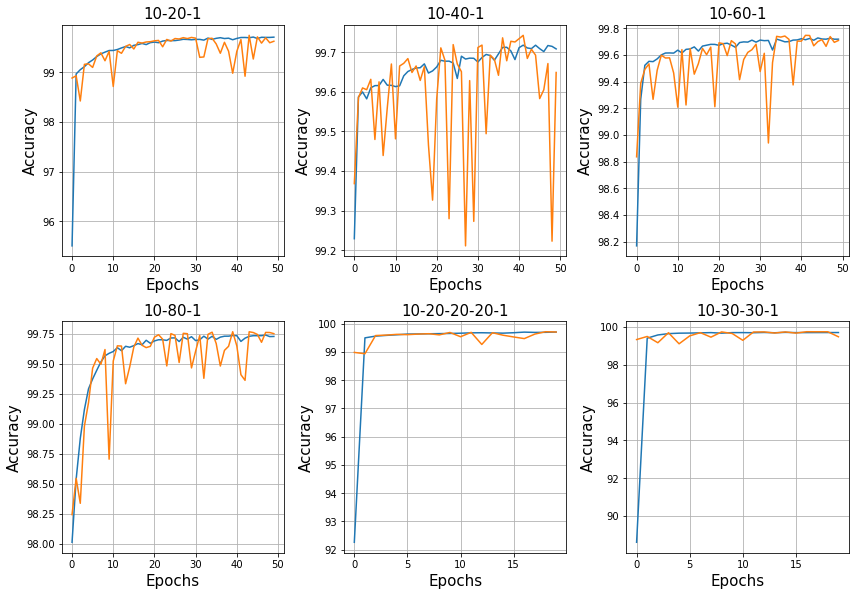

In [310]:
plt.figure(figsize=(12, 12))
plt.title('asd', fontsize = 15)


plt.subplot(331)
plt.plot(100 - np.asarray(history_10_20_1.history['loss']).reshape(-1,1))
plt.plot(100.00 - np.asarray(history_10_20_1.history['val_loss']).reshape(-1,1) )
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title("10-20-1", fontsize = 15)
plt.grid(True)

plt.subplot(332)
plt.plot(100 - np.asarray(history_10_40_1.history['loss']).reshape(-1,1))
plt.plot(100.00 - np.asarray(history_10_40_1.history['val_loss']).reshape(-1,1) )
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title("10-40-1", fontsize = 15)
plt.grid(True)

plt.subplot(333)
plt.plot(100 - np.asarray(history_10_60_1.history['loss']).reshape(-1,1))
plt.plot(100.00 - np.asarray(history_10_60_1.history['val_loss']).reshape(-1,1) )
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title("10-60-1", fontsize = 15)
plt.grid(True)

plt.subplot(334)
plt.plot(100 - np.asarray(history_10_80_1.history['loss']).reshape(-1,1))
plt.plot(100.00 - np.asarray(history_10_80_1.history['val_loss']).reshape(-1,1) )
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title("10-80-1", fontsize = 15)
plt.grid(True)


plt.subplot(335)
plt.plot(100 - np.asarray(history_10_20_20_20_1.history['loss']).reshape(-1,1))
plt.plot(100.00 - np.asarray(history_10_20_20_20_1.history['val_loss']).reshape(-1,1) )
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title("10-20-20-20-1", fontsize = 15)
plt.grid(True)

plt.subplot(336)
plt.plot(100 - np.asarray(history_10_30_30_1.history['loss']).reshape(-1,1))
plt.plot(100.00 - np.asarray(history_10_30_30_1.history['val_loss']).reshape(-1,1) )
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title("10-30-30-1", fontsize = 15)
plt.grid(True)
plt.tight_layout()
plt.savefig('./images/10-prior_day_training_plot.jpg')

### Plotting all the predictions with 10-prior days and Displaying MSE of each models

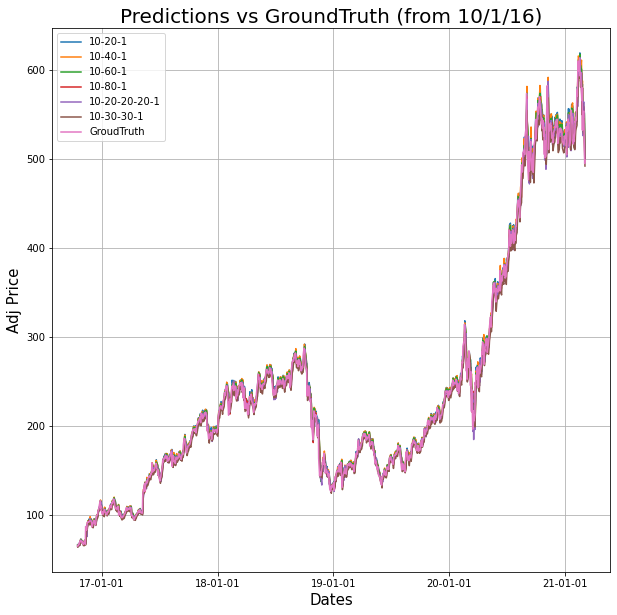

In [324]:
# Prediction
y_test_pred_10_20_1 = model_10_20_1.predict(x_10_test)
y_test_pred_10_40_1 = model_10_40_1.predict(x_10_test)
y_test_pred_10_60_1 = model_10_60_1.predict(x_10_test)
y_test_pred_10_80_1 = model_10_80_1.predict(x_10_test)
y_test_pred_10_20_20_20_1 = model_10_20_20_20_1.predict(x_10_test)
y_test_pred_10_30_30_1 = model_10_30_30_1.predict(x_10_test)

# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.plot(date[-1103:], y_test_pred_10_20_1) 
ax.plot(date[-1103:], y_test_pred_10_40_1) 
ax.plot(date[-1103:], y_test_pred_10_60_1) 
ax.plot(date[-1103:], y_test_pred_10_80_1) 
ax.plot(date[-1103:], y_test_pred_10_20_20_20_1) 
ax.plot(date[-1103:], y_test_pred_10_30_30_1) 
ax.plot(date[-1103:], y_10_test)

# Define the date format
date_form = DateFormatter("%y-%m-%d")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))

# Add plot details
plt.xlabel('Dates', fontsize = 15)
plt.ylabel('Adj Price', fontsize = 15)
plt.grid(True)
plt.title('Predictions vs GroundTruth (from 10/1/16)', fontsize = 20)
plt.legend(['10-20-1','10-40-1','10-60-1','10-80-1','10-20-20-20-1','10-30-30-1','GroudTruth'])

plt.savefig('./images/10-prior_day_prediction_plot.jpg')
plt.show()


### MSE of each performance

In [292]:

y_test_pred_10_20_1 = model_10_20_1.predict(x_10_test)
y_test_pred_10_40_1 = model_10_40_1.predict(x_10_test)
y_test_pred_10_60_1 = model_10_60_1.predict(x_10_test)
y_test_pred_10_80_1 = model_10_80_1.predict(x_10_test)
y_test_pred_10_20_20_20_1 = model_10_20_20_20_1.predict(x_10_test)
y_test_pred_10_30_30_1 = model_10_30_30_1.predict(x_10_test)


from sklearn.metrics import mean_squared_error
print('Average accuracy (MSE) of the adjusted closing prices on the test data with 10-20-1 is:{:.2f}'.format(mean_squared_error(y_10_test, y_test_pred_10_20_1)))
print('Average accuracy (MSE) of the adjusted closing prices on the test data with 10-40-1 is:{:.2f}'.format(mean_squared_error(y_10_test, y_test_pred_10_40_1)))
print('Average accuracy (MSE) of the adjusted closing prices on the test data with 10-60-1 is:{:.2f}'.format(mean_squared_error(y_10_test, y_test_pred_10_60_1)))
print('Average accuracy (MSE) of the adjusted closing prices on the test data with 10-80-1 is:{:.2f}'.format(mean_squared_error(y_10_test, y_test_pred_10_80_1)))
print('Average accuracy (MSE) of the adjusted closing prices on the test data with 10-40-1 is:{:.2f}'.format(mean_squared_error(y_10_test, y_test_pred_10_20_20_20_1)))
print('Average accuracy (MSE) of the adjusted closing prices on the test data with 10-80-1 is:{:.2f}'.format(mean_squared_error(y_10_test, y_test_pred_10_30_30_1)))

Average accuracy (MSE) of the adjusted closing prices on the test data with 10-20-1 is:82.45
Average accuracy (MSE) of the adjusted closing prices on the test data with 10-40-1 is:79.55
Average accuracy (MSE) of the adjusted closing prices on the test data with 10-60-1 is:72.01
Average accuracy (MSE) of the adjusted closing prices on the test data with 10-80-1 is:66.92
Average accuracy (MSE) of the adjusted closing prices on the test data with 10-40-1 is:77.24
Average accuracy (MSE) of the adjusted closing prices on the test data with 10-80-1 is:98.25


### Plotting all the MSE model performances of with 7- and 10-prior days input layer

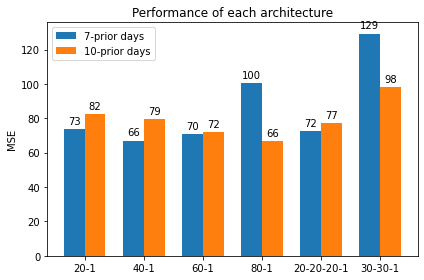

In [325]:
labels = ['20-1', '40-1', '60-1', '80-1', '20-20-20-1', '30-30-1']
prior_7  = [mean_squared_error(y_7_test, y_test_pred_7_20_1),
            mean_squared_error(y_7_test, y_test_pred_7_40_1),
            mean_squared_error(y_7_test, y_test_pred_7_60_1),
            mean_squared_error(y_7_test, y_test_pred_7_80_1),
            mean_squared_error(y_7_test, y_test_pred_7_20_20_20_1),
            mean_squared_error(y_7_test, y_test_pred_7_30_30_1)]

prior_10 = [mean_squared_error(y_10_test, y_test_pred_10_20_1),
            mean_squared_error(y_10_test, y_test_pred_10_40_1),
            mean_squared_error(y_10_test, y_test_pred_10_60_1),
            mean_squared_error(y_10_test, y_test_pred_10_80_1),
            mean_squared_error(y_10_test, y_test_pred_10_20_20_20_1),
            mean_squared_error(y_10_test, y_test_pred_10_30_30_1)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, prior_7, width, label='7-prior days')
rects2 = ax.bar(x + width/2, prior_10, width, label='10-prior days')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('Performance of each architecture')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(int(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.savefig('./images/10-_7-prior_day_MSE_plot.jpg')
plt.show()

## Q(f)
Bonus for all: (5 points) Use the best model you have to predict the adjusted closing price of NVDA on
Wednesday, 3/24. 

## My response
Based on MSE, my best model is 7-40-1 architecture. My prediction is $525.62.

In [326]:
df2 = pd.read_csv('NVDA2.csv')
Q_f = df2['Adj Close'].to_numpy()
Q_f = np.array(Q_f)[np.newaxis]
print('my prediction on 3/25 is {:.2f}'.format(model_7_40_1.predict(Q_f)[0][0]))
df2

my prediction on 3/25 is 525.62


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-03-15,514.590027,528.270020,510.690002,527.650024,527.650024,5549700
1,2021-03-16,534.260010,540.500000,524.669983,531.650024,531.650024,6771200
2,2021-03-17,521.590027,538.130005,519.580017,533.650024,533.650024,6057200
3,2021-03-18,525.460022,527.359985,508.679993,508.899994,508.899994,7347400
4,2021-03-19,510.000000,516.859985,504.500000,513.830017,513.830017,7467100
5,2021-03-22,516.510010,535.780029,516.270020,527.450012,527.450012,7445100
6,2021-03-23,530.169983,533.780029,520.849976,522.830017,522.830017,5541800
